# Further Data PreProcessing

### Import useful libraries, some of them should be pip in the current environment (terminal).

In [1]:
import nltk  # pip; natural language toolkit
import pandas as pd  # pip
import matplotlib.pyplot as plt  # pip
import random

# relevant nltk resources for further data preprocessing
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

random.seed(992)  # random seed

[nltk_data] Downloading package stopwords to /Users/550c/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/550c/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/550c/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Function Abstraction: the common patterns were extracted to avoid code redundancy and verbosity, increasing code reusability.

In [2]:
def view_data(data):
    print("The shape of data: ", data.shape)
    print("The first 10 rows: \n", data.head(10))


def check_NaN(data):
    print("Checking NaN......")
    nan_exist = data.isna().any(axis=0).any()  # output of "data.isna().any(axis=0)"  might be  "content: True; score: False"
    
    if nan_exist:
        nan_rows = data[data.isna().any(axis=1)]  # rows
        amount = len(nan_rows) # how many NaN review rows the data had

        print("The NaN rows: \n{}\n\nThe number of rows with NaN: {}".format(nan_rows, amount))

        print("Deleting......")
        data.dropna(axis=0, inplace=True)  # drop the rows containing NaN
        print("These rows with NaN had been removed!")
        
    else:
        print("No NaN data detected")
        

def draw_distribution(data):
    # draw a bar chart to describe emotion label distribution
    positive_amount = data[data["emotion_label"] == "positive"].shape[0]
    neutral_amount = data[data["emotion_label"] == "neutral"].shape[0]
    negative_amount = data[data["emotion_label"] == "negative"].shape[0]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(["Positive", "Neutral", "Negative"], [positive_amount, neutral_amount, negative_amount], color=["green", "blue", "red"])
    plt.title("Emotion Label Distribution")
    plt.xticks(["Positive", "Neutral", "Negative"])
    plt.xlabel("Categories of reviews")
    plt.ylabel("Amount")
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha="center", va="bottom")  # show exact digits
    plt.show()

# *Manually checking the SentiStrength's emotion scores and labels based on personal subjectivity: First examining the scores of two emotions. Then comparing their absolute values to determine the final emotion label.*

### Inspect possible human errors during the manual checking process.

In [3]:
# data_path = "./data/FINISH_manual_check_data.xlsx"  # the version when the data manually checking was just finished

# This was a perfect version, potential errors introduced by manual checking process, had been corrected.
data_path = "./data/manual_check_data.xlsx"  

data = pd.read_excel(data_path, sheet_name = "original")
view_data(data)

The shape of data:  (7741, 6)
The first 10 rows: 
    manual_index                                            content  length  \
0         63864  ver 12.14.1, delete all data menu not function...      23   
1         37176  used to be good. too many pop ups, ads article...      13   
2         40583  i couldn't even sign up i contacted fliphelp n...      12   
3         18714  for what i know about this app and it works re...      19   
4         47785  love the app, though on occasions what is play...      95   
5         55017  one of the best ways to store your pictures an...      21   
6         32254  x formally twitter is a good place to chat abo...      25   
7         51699  this application is organized for only showing...      23   
8          4886  everything is good but whatapp please update y...       9   
9          2210  i enabled two factor authentication in faceboo...      18   

   positive  negative emotion_label  
0       2.0        -2       neutral  
1       2.0   

In [4]:
# During the manual checking process, if a comment was considered as the unrepresentative one, 
# delete that review in the "content" column; afterwards, this review would be detected and dropped as NaN value.

check_NaN(data)
print("")
check_NaN(data)
print("")
view_data(data)

data = data[~(data["content"].str.isspace() | (data["content"] == ""))]  # check the null value further
view_data

Checking NaN......
The NaN rows: 
      manual_index content  length  positive  negative emotion_label
165          22422     NaN      18       3.0        -2      positive
173          21348     NaN      10       2.0        -1      positive
193           2212     NaN      16       2.0        -1      positive
195          62116     NaN      57       2.0        -2       neutral
211          48285     NaN      34       2.0        -4      negative
...            ...     ...     ...       ...       ...           ...
7710         21387     NaN      16       1.0        -1       neutral
7719         27117     NaN       8       2.0        -1      positive
7723         21767     NaN      24       4.0        -1      positive
7735          7580     NaN      55       2.0        -1      positive
7738         32432     NaN      13       1.0        -1       neutral

[2452 rows x 6 columns]

The number of rows with NaN: 2452
Deleting......
These rows with NaN had been removed!

Checking NaN......
No Na

<function __main__.view_data(data)>

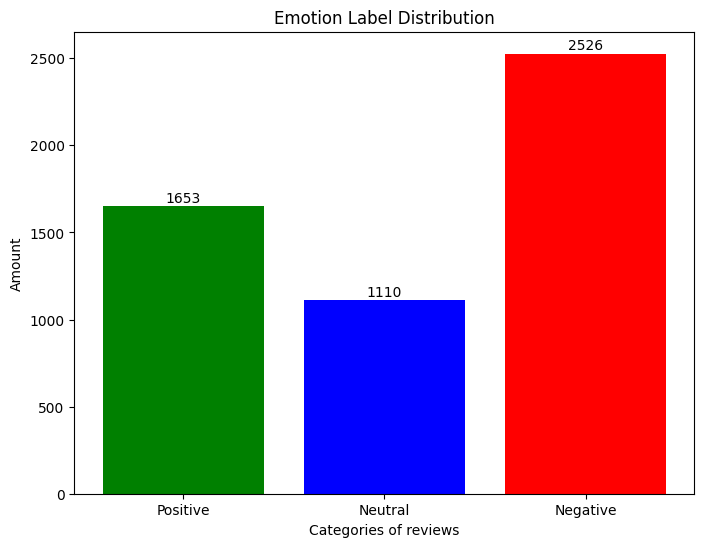

In [5]:
# draw the bar chart to describe emotion label distribution after the manual checking process
draw_distribution(data)  

In [6]:
# Check if there were reviews whose emotional scores did not meet standards: 
# positive scores range from 1 to 5, and negative scores range from -1 to -5. 
# This was crucial for subsequent experiments.

data_with_invalid_negative = data[~data["negative"].isin([-1, -2, -3, -4, -5])]
data_with_invalid_positive = data[~data["positive"].isin([1, 2, 3, 4, 5])]

print("Index for Invalid Negative Values:", data_with_invalid_negative["manual_index"].tolist())
print("Index for Invalid Positive Values:", data_with_invalid_positive["manual_index"].tolist())

Index for Invalid Negative Values: []
Index for Invalid Positive Values: []


In [7]:
# Verify whether the final emotion label of app reviews was calculated correctly during the manual checking process, 
# which involved comparing absolute values of the two emotional scores.

data["calculated_emotion_label"] = data.apply(
                                                lambda row: "positive" if abs(row["positive"]) > abs(row["negative"])
                                                else ("negative" if abs(row["negative"]) > abs(row["positive"])
                                                else "neutral"), axis=1)

mismatches = data[ data["emotion_label"] != data["calculated_emotion_label"] ]

print(f"There were totally {mismatches.shape[0]} emotion labels not matched.")  # how many rows?
print(mismatches)

There were totally 0 emotion labels not matched.
Empty DataFrame
Columns: [manual_index, content, length, positive, negative, emotion_label, calculated_emotion_label]
Index: []


In [8]:
# Re-examine briefly using the attribute of length.
data["length_check"] = data["content"].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
data_with_mismatched_length = data[ data["length_check"] != data["length"] ]

print("Index for Mismatched Content Length:", data_with_mismatched_length["manual_index"].tolist())

Index for Mismatched Content Length: []


In [9]:
# Discard columns created for auxiliary inspection.
data.drop(["calculated_emotion_label", "length_check"], axis=1, inplace=True)   
view_data(data)
data.to_excel("./data/processed_data_after_manual.xlsx", index = False, sheet_name = "processed") 

The shape of data:  (5289, 6)
The first 10 rows: 
    manual_index                                            content  length  \
0         63864  ver 12.14.1, delete all data menu not function...      23   
1         37176  used to be good. too many pop ups, ads article...      13   
2         40583  i couldn't even sign up i contacted fliphelp n...      12   
3         18714  for what i know about this app and it works re...      19   
4         47785  love the app, though on occasions what is play...      95   
5         55017  one of the best ways to store your pictures an...      21   
6         32254  x formally twitter is a good place to chat abo...      25   
7         51699  this application is organized for only showing...      23   
8          4886  everything is good but whatapp please update y...       9   
9          2210  i enabled two factor authentication in faceboo...      18   

   positive  negative emotion_label  
0       2.0        -2       neutral  
1       2.0   

# *At this moment, the emotion scores and labels, which were manually checked, had been inspected further to avoid errors that may be introduced during the manual checking process.*

# Further Data PreProcessing for subsequent experiments

### Read the data, which had been manually checked and insepcted further.

In [10]:
data_path = "./data/processed_data_after_manual.xlsx"
data = pd.read_excel(data_path, sheet_name = "processed")
view_data(data)

The shape of data:  (5289, 6)
The first 10 rows: 
    manual_index                                            content  length  \
0         63864  ver 12.14.1, delete all data menu not function...      23   
1         37176  used to be good. too many pop ups, ads article...      13   
2         40583  i couldn't even sign up i contacted fliphelp n...      12   
3         18714  for what i know about this app and it works re...      19   
4         47785  love the app, though on occasions what is play...      95   
5         55017  one of the best ways to store your pictures an...      21   
6         32254  x formally twitter is a good place to chat abo...      25   
7         51699  this application is organized for only showing...      23   
8          4886  everything is good but whatapp please update y...       9   
9          2210  i enabled two factor authentication in faceboo...      18   

   positive  negative emotion_label  
0         2        -2       neutral  
1         2   

In [11]:
# the tokenizer tool, converting the stream of words into tokens
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=False)  # reduce_len: "sooooo" -> "so"

### Remove some of stop words from the app reviews.

In [12]:
custom_stop_words = {   
                     'be', 'am', 'is', 'are', 'was', 'were', 'being', 'been', 
                     'i', 'me', 'we', 'my', 'mine', 'our', 'us', 'ours', 'you', 'your', 'yours', 'he', 'she', 'hers', 'they', 'him', 'her', 'them', 'his', 'its', 'it',
                     'myself', 'yourself', 'itself', 'herself', 'himself',
                     'i\'m', 'you\'re', 'it\'s', 'he\'s', 'she\'s',
                     'their', 'theirs', 'this', 'that', 'these', 'those',
                     'have', 'has', 'had',
                     'here', 'there',
                     'the', 'a', 'an', 'and', 'because', 'do', 'does', 'did',
                     'at', 'by', 'for', 'of', 'to', 'with', 'during', 'including', 'in', 'on', 'about', 'between', 'into', 'through', 'as'
                    }

processed_data = []
for review in data["content"]:
    tokens = tokenizer.tokenize(review)  # TweetTokenizer
    filtered_words = [word for word in tokens if word not in custom_stop_words]  # drop some of stop words
    processed_text = ' '.join(filtered_words)  # combine these filtered tokens
    processed_data.append(processed_text)  # one review was finished

data["some_stop_words"] = processed_data  # conserve the processed data
view_data(data)

The shape of data:  (5289, 7)
The first 10 rows: 
    manual_index                                            content  length  \
0         63864  ver 12.14.1, delete all data menu not function...      23   
1         37176  used to be good. too many pop ups, ads article...      13   
2         40583  i couldn't even sign up i contacted fliphelp n...      12   
3         18714  for what i know about this app and it works re...      19   
4         47785  love the app, though on occasions what is play...      95   
5         55017  one of the best ways to store your pictures an...      21   
6         32254  x formally twitter is a good place to chat abo...      25   
7         51699  this application is organized for only showing...      23   
8          4886  everything is good but whatapp please update y...       9   
9          2210  i enabled two factor authentication in faceboo...      18   

   positive  negative emotion_label  \
0         2        -2       neutral   
1         2 

### Perform stemming on the reviews.

In [13]:
stemmer = PorterStemmer()  # the initialized instance for "PorterStemmer()"

processed_data = []
for review in data["content"]:
    tokens = tokenizer.tokenize(review)  # TweetTokenizer
    stemmed_words = [stemmer.stem(word) for word in tokens]  # perform the stemming operation for each token
    processed_text = ' '.join(stemmed_words)  # combine these filtered tokens
    processed_data.append(processed_text)  # one review was finished

data["stem"] = processed_data  # conserve the processed data
view_data(data)

The shape of data:  (5289, 8)
The first 10 rows: 
    manual_index                                            content  length  \
0         63864  ver 12.14.1, delete all data menu not function...      23   
1         37176  used to be good. too many pop ups, ads article...      13   
2         40583  i couldn't even sign up i contacted fliphelp n...      12   
3         18714  for what i know about this app and it works re...      19   
4         47785  love the app, though on occasions what is play...      95   
5         55017  one of the best ways to store your pictures an...      21   
6         32254  x formally twitter is a good place to chat abo...      25   
7         51699  this application is organized for only showing...      23   
8          4886  everything is good but whatapp please update y...       9   
9          2210  i enabled two factor authentication in faceboo...      18   

   positive  negative emotion_label  \
0         2        -2       neutral   
1         2 

### Perform lemmatization on the reviews.

In [14]:
lemmatizer = WordNetLemmatizer()  # the initialized instance for "WordNetLemmatizer()"

processed_data = []
for review in data["content"]:
    tokens = tokenizer.tokenize(review)  # TweetTokenizer
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]  # perform the lemmatization operation for each token
    processed_text = ' '.join(lemmatized_words)  # combine these filtered tokens
    processed_data.append(processed_text)  # one review was finished

data["lemm"] = processed_data  # conserve the processed data
view_data(data)

The shape of data:  (5289, 9)
The first 10 rows: 
    manual_index                                            content  length  \
0         63864  ver 12.14.1, delete all data menu not function...      23   
1         37176  used to be good. too many pop ups, ads article...      13   
2         40583  i couldn't even sign up i contacted fliphelp n...      12   
3         18714  for what i know about this app and it works re...      19   
4         47785  love the app, though on occasions what is play...      95   
5         55017  one of the best ways to store your pictures an...      21   
6         32254  x formally twitter is a good place to chat abo...      25   
7         51699  this application is organized for only showing...      23   
8          4886  everything is good but whatapp please update y...       9   
9          2210  i enabled two factor authentication in faceboo...      18   

   positive  negative emotion_label  \
0         2        -2       neutral   
1         2 

### Remove all stop words from the app reviews.

In [15]:
stop_words = set(stopwords.words("english"))  # stop words resource from the Natural Language Toolkit (NLTK)

processed_data = []
for review in data["content"]:
    tokens = tokenizer.tokenize(review)  # TweetTokenizer
    filtered_words = [word for word in tokens if word not in stop_words]  # drop all stop words
    processed_text = ' '.join(filtered_words)  # combine these filtered tokens
    processed_data.append(processed_text)  # one review was finished

data["all_stop_words"] = processed_data  # conserve the processed data
view_data(data)

The shape of data:  (5289, 10)
The first 10 rows: 
    manual_index                                            content  length  \
0         63864  ver 12.14.1, delete all data menu not function...      23   
1         37176  used to be good. too many pop ups, ads article...      13   
2         40583  i couldn't even sign up i contacted fliphelp n...      12   
3         18714  for what i know about this app and it works re...      19   
4         47785  love the app, though on occasions what is play...      95   
5         55017  one of the best ways to store your pictures an...      21   
6         32254  x formally twitter is a good place to chat abo...      25   
7         51699  this application is organized for only showing...      23   
8          4886  everything is good but whatapp please update y...       9   
9          2210  i enabled two factor authentication in faceboo...      18   

   positive  negative emotion_label  \
0         2        -2       neutral   
1         2

### Assemble these approaches.

In [16]:
# processed_data = []
# for review in data["content"]:
#     tokens = tokenizer.tokenize(review)
#     filtered_words = [word for word in tokens if word not in custom_stop_words]  # drop some of stop words
#     stemmed_words = [stemmer.stem(word) for word in filtered_words]  # stem
#     lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]  # lemm
#     processed_text = ' '.join(filtered_words)
#     processed_data.append(processed_text)

# data["power_combine"] = processed_data
# view_data(data)

In [17]:
data.to_excel("./data/processed_data_after_manual.xlsx", index = False, sheet_name = "processed")  # need "pip install openpy" command in the terminal

### Data Augmentation.

In [18]:
def synonym_replacement(word):
    synonyms = set()  # null set
    for syn in wordnet.synsets(word):  # one word probably had different meanings (different synonym sets)
        for lemma in syn.lemmas():  # using lemmas() to catch every element (word or phrase) for each synonym set
            synonyms.add(lemma.name().replace('_', ' '))  # replace() for phrase: "ice_cream" -> "ice cream"

    if len(synonyms) > 0:  # if the synonym existed, randomly return one
        return random.choice(list(synonyms))
    else:
        return word  # if the synonym did not exist, just return the original word


def is_word_eligible(word):
    # avoiding errors caused by encountering numbers and special characters
    return word.isalpha()


def augment_sentence_with_synonym(sentence):
    words = sentence.split()

    eligible_words = [word for word in words if is_word_eligible(word)]  # ignore numbers and special characters
    if not eligible_words:  # if no word met the criteria, return the original sentence directly
        return sentence
        
    random_word = random.choice(eligible_words)  # randomly select one word
    new_word = synonym_replacement(random_word)  # find the synonym of this word
    
    # replace that selected word in the original sentence
    new_words = [new_word if word == random_word else word for word in words]
    new_sentence = ' '.join(new_words)  # combine these separate words into one whole sentence
    
    return new_sentence

In [19]:
data_path = "./data/processed_data_after_manual.xlsx"
data = pd.read_excel(data_path, sheet_name = "processed")
data.drop(["some_stop_words", "stem", "lemm", "all_stop_words"], axis=1, inplace=True)  # prepare for the new sheet

augmented_data = []  # conserve the augmented data
for index, row in data.iterrows():
    sentence = row["content"]  # obtain the sentence intended for the augmentation
    augmented_sentence = augment_sentence_with_synonym(sentence)  # Data Augmentation Operation
    if augmented_sentence != sentence:  # successful argumentation
        new_row = row.copy()  # the copied Series Object for the original data (with emotion scores and labels)
        new_row["content"] = augmented_sentence  # replace the review content in that copied data
        augmented_data.append(new_row)

augmented_data = pd.DataFrame(augmented_data)
view_data(augmented_data)  # HOW MANY augmentation reviews were created?

combined_data = pd.concat([data, augmented_data])  # combine the original reviews with the augmentation reviews
view_data(combined_data)

output_path = "./data/processed_data_after_manual.xlsx"
with pd.ExcelWriter(output_path, engine="openpyxl", mode="a") as writer:
    combined_data.to_excel(writer, sheet_name = "augmentation", index=False)  # new sheet at the same file address

The shape of data:  (3313, 6)
The first 10 rows: 
     manual_index                                            content  length  \
0          63864  ver 12.14.1, delete all information menu not f...      23   
1          37176  put-upon to be good. too many pop ups, ads art...      13   
2          40583  i couldn't even sign up i get hold of fliphelp...      12   
3          18714  for what i know about this app and it works re...      19   
4          47785  love the app, though on occasions what is play...      95   
6          32254  x formally twitter is a good place to chat abo...      25   
9           2210  i enabled two factor authentication in faceboo...      18   
10         52600  why did u auto enabled ai data sharing feature...      11   
12         60070  line please bring back posts feature where you...      27   
13         20689        good app,, all options are hand to make ppt       9   

    positive  negative emotion_label  
0          2        -2       neutral  
1

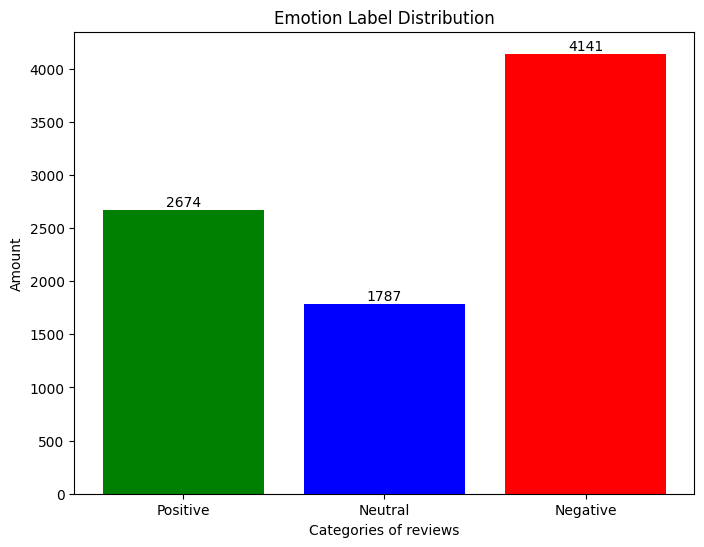

In [20]:
# draw the bar chart to describe emotion label distribution after data augmentation
draw_distribution(combined_data)